In [41]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Options
DISPLAY = 1
MAKE_PLOTS = 1
COMPUTE_MPC = 1

# Set Parameters

# Preferences and Returns
risk_aver = 1.0  # Coefficient of relative risk aversion
rho = 0.0057  # Discount rate (quarterly)
r = 0.005     # Interest rate (quarterly)

# Income Risk (Discretized Normal)
arrivalrate_y = 0.25 # Transition frequency
mu_y = 1.0
sd_y = 0.25
ny = 5

# Asset Grid Settings
na = 100
amax = 50
borrow_lim = 0
agrid_par = 0.4 # Curvature (0.4 = more points near borrowing limit)

# Computation Settings
maxiter_hjb = 50
tol_hjb = 1.0e-10
delta_hjb = 1.0e8 # Step size for semi-implicit method

In [42]:
# Create Grids 

# Create Asset Grid
agrid = np.linspace(0, 1, na)
agrid = agrid**(1.0 / agrid_par)
agrid = borrow_lim + (amax - borrow_lim) * agrid

# Grid Spacing for Derivatives
dagrid = np.diff(agrid)
dagridf = np.append(dagrid, dagrid[-1]) # Forward
dagridb = np.insert(dagrid, 0, dagrid[0]) # Backward

# Trapezoidal Rule for Integration (KFE)
adelta = np.zeros(na)
adelta[0] = 0.5 * dagrid[0]
adelta[1:-1] = 0.5 * dagrid[:-1] + 0.5 * dagrid[1:]
adelta[-1] = 0.5 * dagrid[-1]

# Helper Function: Discretize Normal Distribution
def discrete_normal(n, mu, sigma, width):
    x = np.linspace(mu - width * sigma, mu + width * sigma, n)
    if n == 2:
        p = np.array([0.5, 0.5])
    else:
        p = np.zeros(n)
        dx = x[1] - x[0]
        p[0] = sp.stats.norm.cdf(x[0] + 0.5 * dx, mu, sigma)
        for i in range(1, n-1):
            p[i] = sp.stats.norm.cdf(x[i] + 0.5 * dx, mu, sigma) - \
                   sp.stats.norm.cdf(x[i] - 0.5 * dx, mu, sigma)
        p[-1] = 1 - np.sum(p[:-1])

    variance = np.sum(p * x**2) - np.sum(p * x)**2
    sd_x = np.sqrt(np.maximum(variance, 0))
    return sd_x - sigma, x, p

# Find grid width that matches target standard deviation
from scipy.optimize import brentq
# 1. Define the objective function (what we want to be zero)
def objective(w):
    error, _, _ = discrete_normal(ny, mu_y, sd_y, w)
    return error
# 2. Use brentq (bisection-based) to find the width
# We search for the width between 1.0 and 10.0 standard deviations
width_opt = brentq(objective, 0.0001, 5.0)
# 3. Generate the final grids using the optimal width
_, ygrid, ydist = discrete_normal(ny, mu_y, sd_y, width_opt)

# 2D Grids
aagrid = np.tile(agrid.reshape(-1, 1), (1, ny))
yygrid = np.tile(ygrid, (na, 1))
aydelta = np.tile(adelta.reshape(-1, 1), (1, ny))

# Income Transition Matrix
ytrans = -arrivalrate_y * np.eye(ny) + arrivalrate_y * np.tile(ydist, (ny, 1))
# check that rows sum to zero
crit = np.max(np.abs(np.sum(ytrans, axis=1)))
if crit > 1e-9:
    raise ValueError("Income transition matrix rows do not sum to zero")

yytrans = sparse.kron(sparse.csr_matrix(ytrans), sparse.eye(na))

In [43]:
# Define Utility Function

if risk_aver == 1:
    u = lambda c: np.log(np.maximum(c, 1e-10))
else:
    u = lambda c: (c**(1-risk_aver) - 1) / (1 - risk_aver)

u1 = lambda c: c**(-risk_aver)
u1inv = lambda v: v**(-1.0 / risk_aver)

In [44]:
# INITIALIZE VALUE FUNCTION
Vguess = np.zeros((na, ny))
for iy in range(ny):
    # Initial guess: consume interest and income (zero savings)
    Vguess[:, iy] = u(r * agrid + ygrid[iy]) / rho

V = Vguess.copy()
Vvec = V.flatten(order='F') # Flatten in Fortran order for column-major matrix logic

Vdiff = 1.0
iter = 0

In [45]:
# Value Function Iteration (HJB)

while iter < maxiter_hjb and Vdiff > tol_hjb: #type: ignore
    iter += 1
    
    # 1. Finite Differences (dV/da)
    dVf = np.zeros((na, ny))
    dVb = np.zeros((na, ny))
    
    # Forward difference
    dVf[0:na-1, :] = (V[1:na, :] - V[0:na-1, :]) / dagridf[0:na-1, np.newaxis]
    dVf[na-1, :] = u1(r * agrid[na-1] + ygrid) # State constraint at top
    
    # Backward difference
    dVb[1:na, :] = (V[1:na, :] - V[0:na-1, :]) / dagridb[1:na, np.newaxis]
    dVb[0, :] = u1(r * agrid[0] + ygrid) # State constraint at bottom
    
    # 2. Consumption and Hamiltonians for Forward Difference
    conf = u1inv(dVf)
    savf = r * aagrid + yygrid - conf
    Hf = u(conf) + dVf * savf
    
    # 3. Consumption and Hamiltonians for Backward Difference
    conb = u1inv(dVb)
    savb = r * aagrid + yygrid - conb
    Hb = u(conb) + dVb * savb
    
    # 4. Consumption and Hamiltonian for zero savings (adot = 0)
    con0 = r * aagrid + yygrid
    H0 = u(con0)
    
    # 5. UPWIND SCHEME: Choice of Forward or Backward Difference
    # Indicator logic mirrors MATLAB: Ineither, Iunique, Iboth
    If = (savf > 0) * (Hf > H0) * ((Hf > Hb) | (savb >= 0))
    Ib = (savb < 0) * (Hb > H0) * ((Hb > Hf) | (savf <= 0))
    I0 = 1 - If - Ib
    
    # Final policy functions
    con = conf * If + conb * Ib + con0 * I0
    sav = savf * If + savb * Ib
    util = u(con)
    utilvec = util.flatten(order='F')

    # 6. CONSTRUCT TRANSITION MATRIX A (Vectorized)
    # Standardize dimensions into (na*ny) vectors
    savvec = sav.flatten(order='F')
    dfvec = np.tile(dagridf, ny)
    dbvec = np.tile(dagridb, ny)

    # --- BOUNDARY DRIFT CHECKS ---
    # Identify indices for a_min (bottom) and a_max (top) across all income states
    idx_min = np.arange(0, na * ny, na)
    idx_max = np.arange(na - 1, na * ny, na)

    # Check 1: No borrowing below limit (sav at a_min must be >= 0)
    if np.any(savvec[idx_min] < -1e-12):
        error_val = np.min(savvec[idx_min])
        raise ValueError(f"Boundary Violation: sav < 0 at borrow_lim. Min sav: {error_val:.2e}")

    # Check 2: No saving above max assets (sav at a_max must be <= 0)
    if np.any(savvec[idx_max] > 1e-12):
        error_val = np.max(savvec[idx_max])
        raise ValueError(f"Boundary Violation: sav > 0 at amax. Max sav: {error_val:.2e}")

    # Upwind Indicators
    Ib_vec = Ib.flatten(order='F')
    If_vec = If.flatten(order='F')

    # Construct Diagonals (Outflows and Inflows)
    Alowdiag = Ib_vec * (-savvec / dbvec)
    Aupdiag  = If_vec * (savvec / dfvec)
    Adiag    = Ib_vec * (savvec / dbvec) - If_vec * (savvec / dfvec)

    # Build the Sparse Matrix
    # Because drift is zero or inward at boundaries, the [1:] and [:-1] 
    # slices will naturally contain zeros at the block-transition points.
    A_assets = sparse.diags(
        [Adiag, Alowdiag[1:], Aupdiag[:-1]], 
        [0, -1, 1], # type: ignore
        shape=(na*ny, na*ny)
    ).tocsr()

    # Final Transition Matrix: Asset transitions + Poisson Income switches
    A = A_assets + yytrans

    # 7. SOLVE LINEAR SYSTEM (Implicit Updating)
    # B matrix reflects the step size delta_hjb
    B = (rho + 1.0/delta_hjb) * sparse.eye(na*ny) - A
    
    Vvecnew = spsolve(B, utilvec + Vvec/delta_hjb)
    Vnew = Vvecnew.reshape((na, ny), order='F')
    
    Vdiff = np.max(np.abs(Vvecnew - Vvec))
    
    if DISPLAY >= 1:
        print(f"HJB iteration {iter} diff: {Vdiff:.2e}")

    V = Vnew.copy()
    Vvec = Vvecnew.copy()

HJB iteration 1 diff: 1.07e+02
HJB iteration 2 diff: 4.46e+00
HJB iteration 3 diff: 3.21e+00
HJB iteration 4 diff: 4.28e+00
HJB iteration 5 diff: 4.51e+00
HJB iteration 6 diff: 4.59e+00
HJB iteration 7 diff: 1.53e-01
HJB iteration 8 diff: 3.79e-02
HJB iteration 9 diff: 9.36e-03
HJB iteration 10 diff: 1.01e-02
HJB iteration 11 diff: 1.43e-02
HJB iteration 12 diff: 1.52e-02
HJB iteration 13 diff: 9.84e-03
HJB iteration 14 diff: 4.96e-03
HJB iteration 15 diff: 2.00e-03
HJB iteration 16 diff: 3.27e-04
HJB iteration 17 diff: 7.47e-05
HJB iteration 18 diff: 2.67e-05
HJB iteration 19 diff: 6.00e-06
HJB iteration 20 diff: 3.50e-07
HJB iteration 21 diff: 1.21e-09
HJB iteration 22 diff: 2.84e-14


In [46]:
# --- SOLVE KFE USING AUGMENTED SYSTEM ---

# 1. Create the restriction vector (iota)
# This represents the sum of probabilities
iota = np.ones((na*ny, 1))

# 2. Build the Augmented Matrix A_hat = [A' , iota ; iota' , 0]
# We use hstack and vstack to build the (N+1 x N+1) system
A_top = sparse.hstack([A.T, sparse.csr_matrix(iota)], format='csr')
A_bottom = sparse.hstack([
    sparse.csr_matrix(iota.reshape(1, -1)), sparse.csr_matrix([[0]])
], format='csr')
A_hat = sparse.vstack([A_top, A_bottom], format='csr')

# 3. Define the Right-Hand Side (RHS)
# We want A^T * g = 0 and sum(g_adj) = 1
b_full = np.zeros(na*ny + 1)
b_full[-1] = 1.0 

# 4. Solve the linear system
# spsolve is efficient for this augmented sparse structure
lgvecadj = spsolve(A_hat, b_full)

# 5. Extract results and reshape
# x contains [g_1, g_2, ..., g_N, multiplier]
gvecadj = lgvecadj[:-1].reshape(-1, 1)
gmatadj = gvecadj.reshape((na, ny), order='F')

# Adjust for non-uniform grids to get the density g(a,y)
# g(a,y) = g_adj / (delta_a * delta_y)
gmat = gmatadj / aydelta
gamarg = np.sum(gmat, axis=1)

# --- DIAGNOSTICS ---
mean_assets = np.sum(gamarg * agrid * adelta)
if DISPLAY >= 1:
    print(f"KFE Solution Complete.")
    print(f"Total Mass Check: {np.sum(gmatadj):.4f}")
    print(f"Mean Assets: {mean_assets:.4f}")

KFE Solution Complete.
Total Mass Check: 1.0000
Mean Assets: 6.6912


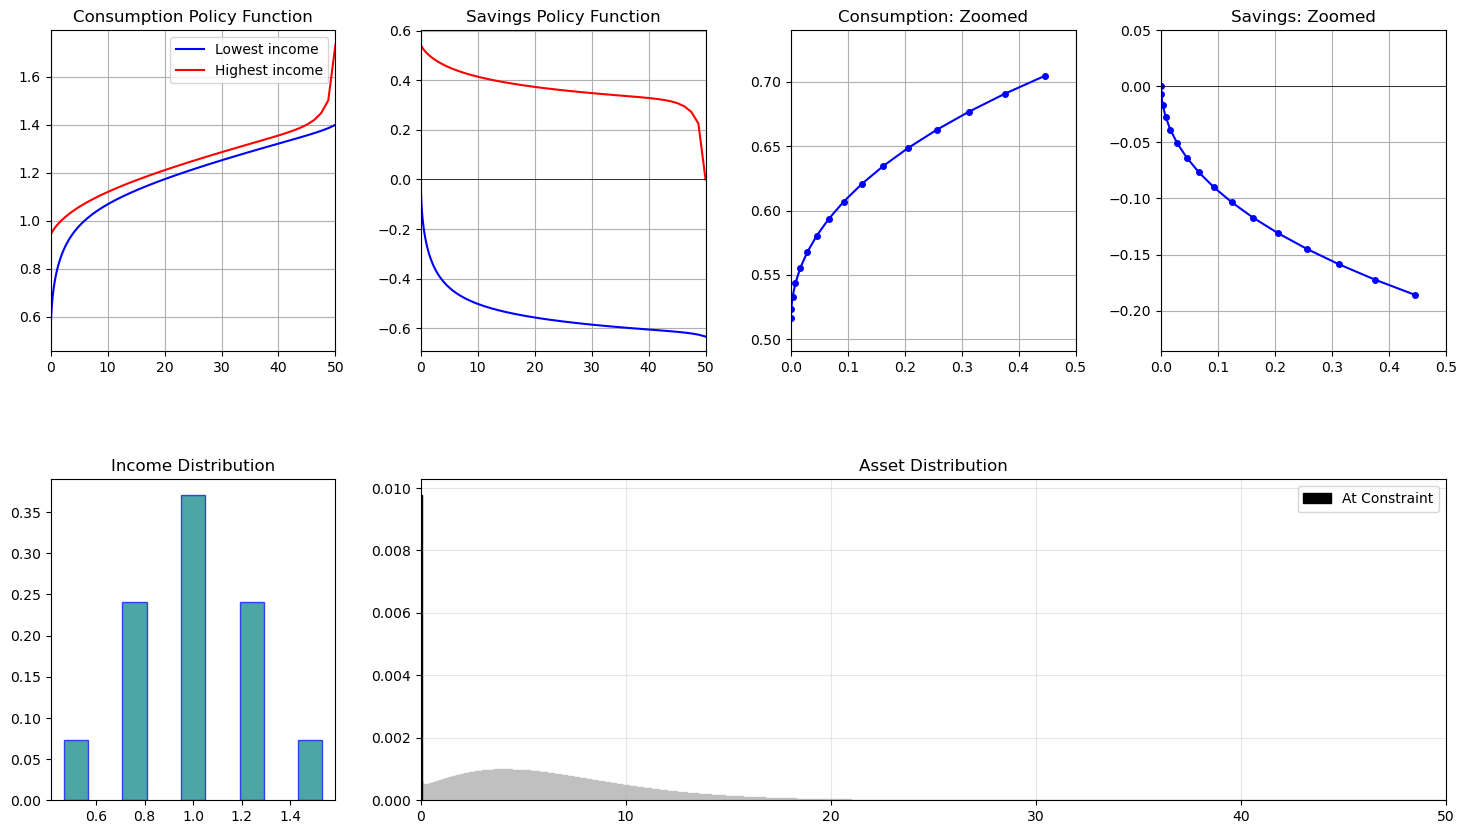

------------------------------
Interest Rate: 0.50% (quarterly)
Discount Rate: 0.57% (quarterly)
Mean Assets: 6.6912
Mean Assets / Mean Income: 6.6912
Fraction Borrowing Constrained: 0.98%
10th Percentile: 1.4525
50th Percentile: 5.7321
90th Percentile: 12.5596
99th Percentile: 20.1550
------------------------------


In [47]:
# Make Plots
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, PchipInterpolator

if MAKE_PLOTS:
    fig = plt.figure(figsize=(18, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # --- 1. Consumption Policy Function ---
    ax1 = plt.subplot(2, 4, 1)
    ax1.plot(agrid, con[:, 0], 'b-', label='Lowest income')
    ax1.plot(agrid, con[:, -1], 'r-', label='Highest income')
    ax1.set_title('Consumption Policy Function')
    ax1.set_xlim([borrow_lim, amax])
    ax1.grid(True)
    ax1.legend()

    # --- 2. Savings Policy Function ---
    ax2 = plt.subplot(2, 4, 2)
    ax2.plot(agrid, sav[:, 0], 'b-', label='Lowest income')
    ax2.plot(agrid, sav[:, -1], 'r-', label='Highest income')
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.set_title('Savings Policy Function')
    ax2.set_xlim([borrow_lim, amax])
    ax2.grid(True)


    # Identify indices where assets are within the zoomed range (0 to 0.5)
    zoom_mask = agrid <= 0.5

    # --- 3. Consumption: Zoomed ---
    ax3 = plt.subplot(2, 4, 3)
    # Plot only the lowest income state (index 0)
    ax3.plot(agrid[zoom_mask], con[zoom_mask, 0], 'b-o', markersize=4)

    # Programmatically set y-limits based on data in this range
    y_min_c = np.min(con[zoom_mask, 0])
    y_max_c = np.max(con[zoom_mask, 0])
    # Add a 5% buffer so points aren't touching the edge
    ax3.set_ylim([y_min_c * 0.95, y_max_c * 1.05])

    ax3.set_title('Consumption: Zoomed')
    ax3.set_xlim([0, 0.5])
    ax3.grid(True)

    # --- 4. Savings: Zoomed ---
    ax4 = plt.subplot(2, 4, 4)
    # Plot only the lowest income state (index 0)
    ax4.plot(agrid[zoom_mask], sav[zoom_mask, 0], 'b-o', markersize=4)
    ax4.axhline(0, color='black', linewidth=0.5)

    # Programmatically set y-limits based on data in this range
    y_min_s = np.min(sav[zoom_mask, 0])
    y_max_s = np.max(sav[zoom_mask, 0])
    # For savings, we usually want to see the 0 line clearly
    ax4.set_ylim([y_min_s - 0.05, max(0.05, y_max_s + 0.05)])

    ax4.set_title('Savings: Zoomed')
    ax4.set_xlim([0, 0.5])
    ax4.grid(True)

    # --- 5. Income Distribution ---
    ax5 = plt.subplot(2, 4, 5)
    ax5.bar(ygrid, ydist, width=0.1, color='teal', edgecolor='blue', alpha=0.7)
    ax5.set_title('Income Distribution')

    # --- 6. Asset Distribution ---
    # Prepare abin for interpolation of the PDF
    abin = np.arange(borrow_lim, amax + 0.01, 0.01)
    nabin = len(abin)
    
    # Calculate CDF and interpolate for the PDF (amass)
    acdf = np.cumsum(adelta * gamarg)
    interpacdf = PchipInterpolator(agrid, acdf)
    
    amass = np.zeros(nabin)
    amass[0] = adelta[0] * gamarg[0]
    # Discrete approximation of density over abin grid
    amass[1:] = interpacdf(abin[1:]) - interpacdf(abin[:-1])
    
    # Identify index for Inverse CDF plotting limit
    # MATLAB: find(acdf > 0.9999999, 1)
    iacdf1_mask = np.where(acdf > 0.9999999)[0]
    iacdf1 = iacdf1_mask[0] if len(iacdf1_mask) > 0 else na - 1
    
    # Inverse CDF for statistics
    interpainvcdf = interp1d(acdf[:iacdf1+1], agrid[:iacdf1+1], fill_value="extrapolate")

    ax6 = plt.subplot(2, 4, (6, 8))
    # Plot mass excluding the first bin (usually the borrowing constraint)
    ax6.bar(abin[1:], amass[1:], width=0.01, color='silver', edgecolor='silver', alpha=0.8)
    # Highlight the borrowing constraint
    ax6.bar(abin[0], amass[0], width=0.1, color='black', edgecolor='black', label='At Constraint')
    ax6.set_xlim([borrow_lim, agrid[min(iacdf1 + 1, na - 1)]])
    ax6.grid(True, alpha=0.3)
    ax6.set_title('Asset Distribution')
    ax6.legend()

    plt.show()

    # --- Asset Distribution Statistics ---
    mean_income = np.sum(ygrid * ydist)
    mean_assets = np.sum(gamarg * agrid * adelta)
    
    print("-" * 30)
    print(f"Interest Rate: {r*100:.2f}% (quarterly)")
    print(f"Discount Rate: {rho*100:.2f}% (quarterly)")
    print(f"Mean Assets: {mean_assets:.4f}")
    print(f"Mean Assets / Mean Income: {mean_assets / mean_income:.4f}")
    print(f"Fraction Borrowing Constrained: {gamarg[0] * adelta[0] * 100:.2f}%")
    print(f"10th Percentile: {interpainvcdf(0.1):.4f}")
    print(f"50th Percentile: {interpainvcdf(0.5):.4f}")
    print(f"90th Percentile: {interpainvcdf(0.9):.4f}")
    print(f"99th Percentile: {interpainvcdf(0.99):.4f}")
    print("-" * 30)

Computing MPCs...


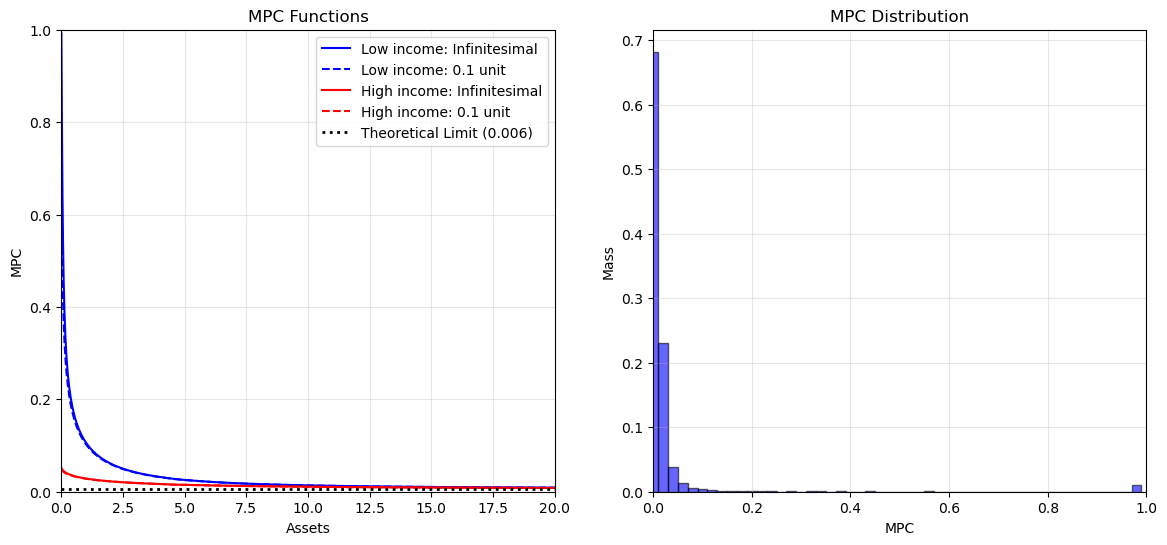

------------------------------
Mean MPC (Infinitesimal): 0.0330
Mean MPC (0.1 units): 0.0269
------------------------------


In [48]:
# --- PARAMETERS FOR MPC CALCULATION ---
cumconT = 1.0       # Duration (e.g., 1 year)
delta_mpc = 0.01    # Time step for backward solve
mpcamount1 = 1e-10  # Theoretical (infinitesimal) MPC
mpcamount2 = 0.1    # MPC for a larger windfall (10% of mean income)

if COMPUTE_MPC:
    if DISPLAY >= 1:
        print("Computing MPCs...")

    # Initialize cumulative consumption
    cumcon = np.zeros((na, ny))
    cumconvec1 = cumcon.flatten(order='F')
    convec = con.flatten(order='F')

    # Solve backwards in time
    # This loop effectively integrates consumption over the interval [0, cumconT]
    for it in np.arange(cumconT, -delta_mpc, -delta_mpc):
        # Implicit update for the cumulative consumption vector
        # System: (I/dt - A) * C_new = c + C_old/dt
        B_mpc = (sparse.eye(na * ny) / delta_mpc) - A
        cumconvec = spsolve(B_mpc, convec + cumconvec1 / delta_mpc)
        cumconvec1 = cumconvec.copy()

    cumcon = cumconvec.reshape((na, ny), order='F')

    # Compute MPCs using interpolation
    mpc1 = np.zeros((na, ny))
    mpc2 = np.zeros((na, ny))
    
    for iy in range(ny):
        # Use PchipInterpolator for a smooth, shape-preserving fit
        interp_func = PchipInterpolator(agrid, cumcon[:, iy])
        
        # MPC = [CumulativeCon(a + Δa) - CumulativeCon(a)] / Δa
        mpc1[:, iy] = (interp_func(agrid + mpcamount1) - cumcon[:, iy]) / mpcamount1
        mpc2[:, iy] = (interp_func(agrid + mpcamount2) - cumcon[:, iy]) / mpcamount2

    # Theoretical MPC lower bound for permanent income consumers
    mpclim = cumconT * ((rho - r) / risk_aver + r)

    # --- PLOT MPC RESULTS ---
    plt.figure(figsize=(14, 6))

    # Subplot 1: MPC Functions
    plt.subplot(1, 2, 1)
    plt.plot(agrid, mpc1[:, 0], 'b-', label='Low income: Infinitesimal')
    plt.plot(agrid, mpc2[:, 0], 'b--', label='Low income: 0.1 unit')
    plt.plot(agrid, mpc1[:, -1], 'r-', label='High income: Infinitesimal')
    plt.plot(agrid, mpc2[:, -1], 'r--', label='High income: 0.1 unit')
    plt.axhline(mpclim, color='black', linestyle=':', linewidth=2, label=f'Theoretical Limit ({mpclim:.3f})')
    
    plt.xlim([0, 20])
    plt.ylim([0, 1])
    plt.title('MPC Functions')
    plt.xlabel('Assets')
    plt.ylabel('MPC')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: MPC Distribution
    # Create bins for the distribution histogram
    mpc_bins = np.linspace(0, 1, 51)
    mpc1_mass, _ = np.histogram(mpc1, bins=mpc_bins, weights=gmatadj)
    
    plt.subplot(1, 2, 2)
    plt.bar(mpc_bins[:-1], mpc1_mass, width=0.02, color='blue', alpha=0.6, edgecolor='black')
    plt.xlim([0, 1])
    plt.title('MPC Distribution')
    plt.xlabel('MPC')
    plt.ylabel('Mass')
    plt.grid(True, alpha=0.3)

    plt.show()

    # Print Summary Statistics
    mean_mpc1 = np.sum(mpc1 * gmatadj)
    mean_mpc2 = np.sum(mpc2 * gmatadj)
    print("-" * 30)
    print(f"Mean MPC (Infinitesimal): {mean_mpc1:.4f}")
    print(f"Mean MPC (0.1 units): {mean_mpc2:.4f}")
    print("-" * 30)